In [1]:
# /home/amarder/anaconda3/envs/minimal_env/bin/python

import warnings
warnings.simplefilter("ignore")
import sys
import os

import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
matplotlib.use("Agg") # Want a non-interactive backend
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as mpdf

from math import log
from scipy import sparse
from matplotlib import cm
from matplotlib import colors
from scipy.sparse import issparse
from scipy.spatial import distance

# Global colour settings
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080',
            '#307D7E', '#000000', '#DDEFFF', '#000035', '#7B4F4B', '#A1C299', '#300018', '#C2FF99', '#0AA6D8', '#013349',
            '#00846F', '#8CD0FF', '#3B9700', '#04F757', '#C8A1A1', '#1E6E00', '#DFFB71', '#868E7E', '#513A01', '#CCAA35',
            '#800080', '#DAA520', '#1E90FF', '#3CB371', '#9370DB', '#8FBC8F', '#00FF7F', '#0000CD', '#556B2F', '#FF00FF',
            '#CD853F', '#6B8E23', '#008000', '#6495ED', '#00FF00', '#DC143C', '#FFFF00', '#00FFFF', '#FF4500', '#4169E1',
            '#48D1CC', '#191970', '#9ACD32', '#FFA500', '#00FA9A', '#2E8B57', '#40E0D0', '#D2691E', '#66CDAA', '#FFEFD5',
            '#20B2AA', '#FF0000', '#EEE8AA', '#BDB76B', '#E9967A', '#AFEEEE', '#000080', '#FF8C00', '#B22222', '#5F9EA0',
            '#ADFF2F', '#FFE4B5', '#7B68EE', '#7FFFD4', '#0000FF', '#BA55D3', '#90EE90', '#FFDAB9', '#6A5ACD', '#8B0000',
            '#8A2BE2', '#CD5C5C', '#F08080', '#228B22', '#FFD700', '#006400', '#98FB98', '#00CED1', '#00008B', '#9400D3',
            '#9932CC', '#4B0082', '#F0E68C', '#483D8B', '#008B8B', '#8B008B', '#4682B4']
myColorTissues = ['#ffe119', '#3cb44b', '#e6194b']

# Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

sns.set(font_scale=1.5)
sns.set_style("white")

idtype="h"
idtype="ds"
# outDir = "/oak/stanford/groups/smontgom/amarder/neuro-variants/output/data/DS_Multiome_h_v2"
# f = "/oak/stanford/groups/smontgom/amarder/neuro-variants/output/data/DS_Multiome_h_v2/Multiome.RNA_only2.h.h5ad"
outDir = "/oak/stanford/groups/smontgom/amarder/neuro-variants/output/data/DS_Multiome_ds_v2"
f = "/oak/stanford/groups/smontgom/amarder/neuro-variants/output/data/DS_Multiome_ds_v2/Multiome.RNA_only2.ds.h5ad"
harmony_to_use = "X_rna_harmony" # "X_harmony"
annotations="subclust_v6"
root_node="HSCs" # for DS
threshold=0.35

outDir = outDir + "/" + "RNA"
# outDir = outDir + "/" + "ATAC"
try:
    os.makedirs(outDir)
except:
    pass


In [2]:
df = sc.read(f)


Only considering the two last: ['.ds', '.h5ad'].
Only considering the two last: ['.ds', '.h5ad'].


In [30]:
chromvardf = pd.read_table("/oak/stanford/groups/smontgom/amarder/neuro-variants/output/data/DS_Multiome_h_v2/h.ChromVAR.txt")

In [31]:
chromvardf

,Unnamed: 0,AAACAGCCACCAAAGG-1_1,AAACAGCCAGGAACAT-1_1,AAACATGCAATGCGCT-1_1,AAACATGCACCGGCTA-1_1,AAACCGAAGGAGGTTA-1_1,AAACCGAAGGTGAAAT-1_1,AAACCGAAGGTTAGAG-1_1,AAACCGGCACCTACTT-1_1,AAACGCGCACCAGCAT-1_1,...,TTTGTGAAGCCTGACA-1_6,TTTGTGGCAAGGATTA-1_6,TTTGTGGCACTAAGAA-1_6,TTTGTGGCATCCCGCT-1_6,TTTGTGTTCACGAATC-1_6,TTTGTGTTCATGGCCA-1_6,TTTGTGTTCCTGGCTT-1_6,TTTGTGTTCTGTGCAG-1_6,TTTGTTGGTAGGTTTG-1_6,TTTGTTGGTTAACGGC-1_6
0,1,-0.060826,-1.113310,1.588116,0.035226,-0.078628,-1.548703,-0.238775,0.182925,-0.735857,...,2.221593,-1.313046,-1.787100,6.001883,3.112439,-1.633313,-2.811820,0.949496,-0.257889,-1.338529
1,2,-1.169488,1.282651,1.396626,0.320050,-0.459576,-1.921863,-0.868443,0.619705,-2.179634,...,0.840188,-0.498414,-1.028936,7.082343,0.958396,-0.570976,-1.831691,-1.241126,0.611107,-2.066807
2,3,-0.855317,5.859125,-2.639194,3.446041,6.046838,-4.956024,-1.888137,5.275166,2.626750,...,5.031048,4.123903,2.817471,2.564617,5.066039,0.155888,0.266967,4.431525,2.542608,1.022365
3,4,-0.208072,-1.064219,-1.232574,0.019514,-1.509483,2.721867,-1.277333,0.459610,2.224366,...,-0.434563,-1.901369,-0.452011,0.342012,-1.601282,0.738223,0.132619,1.914254,1.651444,-1.635031
4,5,2.182189,0.606693,1.464973,1.387504,-0.277913,-1.584797,-1.214222,-0.340557,0.033357,...,-0.937727,0.561686,1.138742,-0.433969,0.043450,-0.449342,2.054632,0.718202,0.319204,0.895727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,629,0.664826,-0.837172,1.106727,1.739581,-0.203807,0.296978,-1.588981,1.390497,-0.556265,...,-2.218602,0.699855,2.939877,2.281716,1.083905,0.748882,4.013492,-0.141028,0.215089,3.353187
629,630,0.492111,-0.186782,1.003330,2.542025,-0.269673,-0.288607,-1.615051,0.681351,-0.392281,...,-2.031292,0.683047,2.694299,2.451410,1.506277,0.497994,5.358853,-0.309146,0.749585,3.903917
630,631,0.699373,1.381378,2.417340,-0.188957,-0.305382,-0.283441,1.104830,-0.139009,0.872818,...,-1.525231,-1.765078,1.056618,0.421291,0.348728,-0.337823,-0.262872,1.155273,-0.951732,-0.308935
631,632,-0.391623,-1.193687,0.484114,-0.008579,-0.882836,-1.209937,-0.800374,1.249511,1.053359,...,1.190727,-0.340398,0.315693,1.875634,0.104443,0.379042,0.707538,1.010414,1.923016,-1.719390


In [8]:
df.layers['chromvar'] =

AnnData object with n_obs × n_vars = 35633 × 36601
    obs: 'nCount_ATAC', 'nFeature_ATAC', 'dataset', 'TSS.enrichment', 'TSS.percentile', 'ATAC_snn_res.1.5', 'seurat_clusters', 'cell', 'dataNum', 'cell_dataset', 'nCount_RNA', 'nFeature_RNA', 'nCount_RNA.1', 'nFeature_RNA.1', 'percent.mt', 'subclust_v5', 'subclust_v6'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_rna_harmony', 'X_umap'
    layers: 'counts'

In [7]:

# # Trajectory analysis with PAGA graphs and a force-directed graph embedding
adata_paga  = df.copy()
adata_paga = adata_paga[~adata_paga.obs[annotations].isin(['Stroma', 'No markers','Unknown'])]

sc.pp.neighbors(adata_paga,
            n_pcs=adata_paga.obsm[harmony_to_use].shape[1],
            use_rep=harmony_to_use,
            knn=True,
            random_state=42,
            method='umap',
            metric='euclidean')

sc.tl.paga(adata_paga, groups=annotations)



In [9]:
adata_paga


AnnData object with n_obs × n_vars = 33489 × 36601
    obs: 'nCount_ATAC', 'nFeature_ATAC', 'dataset', 'TSS.enrichment', 'TSS.percentile', 'ATAC_snn_res.1.5', 'seurat_clusters', 'cell', 'dataNum', 'cell_dataset', 'nCount_RNA', 'nFeature_RNA', 'nCount_RNA.1', 'nFeature_RNA.1', 'percent.mt', 'subclust_v5', 'subclust_v6'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors', 'paga', 'subclust_v6_sizes'
    obsm: 'X_rna_harmony', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

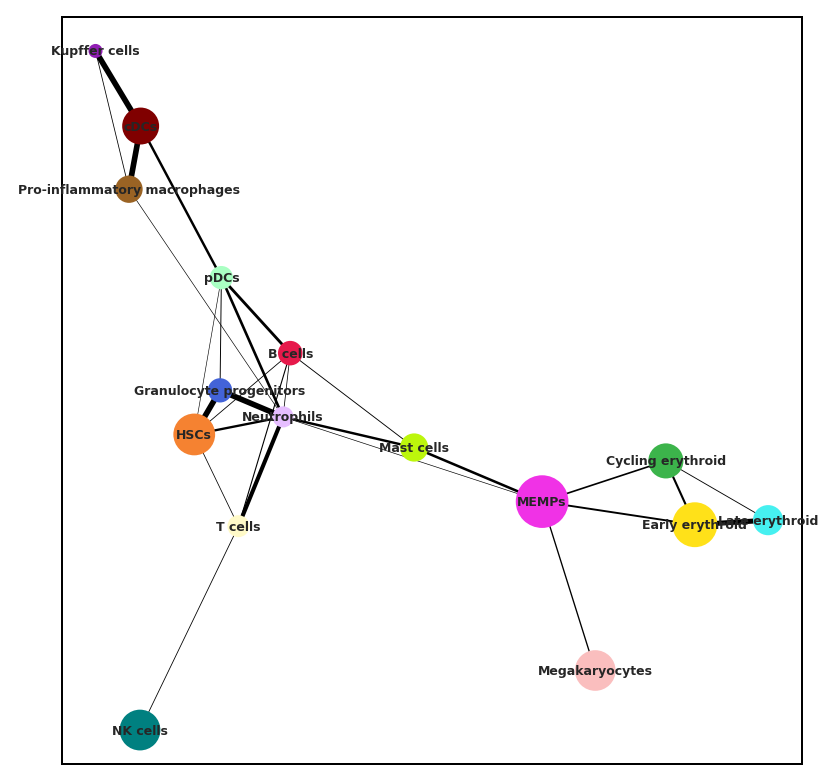

Done.


In [22]:
threshold=0.1
os.chdir(outDir)
sc.settings.set_figure_params(dpi=180, frameon=True, figsize=(5, 5), fontsize=5,facecolor='white')  # low dpi (dots per inch) yields small inline figures
# sc.settings.set_figure_params(dpi=80, frameon=True, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures
f_out=".PAGA_raw_graph_harmony.png"
sc.pl.paga(adata_paga, threshold=threshold, node_size_scale=0.8, edge_width_scale=0.3, fontsize=5, save=f_out,show=True)
# sc.pl.paga(adata_paga, threshold=threshold, node_size_scale=0.8, edge_width_scale=0.3, fontsize=5, save=False,show=True)
# sc.pl.paga(adata_paga)#, save=f_out)
print("Done.")


In [23]:
# sc.tl.draw_graph(adata_paga)

# Recompute the embedding using PAGA initialisation
kwargs = {"maxiter": 1000}
sc.tl.draw_graph(adata_paga,
             init_pos  = 'paga',
             # root      = np.flatnonzero(adata_paga.obs[annotations]==root_node)[0],
             root      = np.flatnonzero(adata_paga.obs[annotations]==root_node)[1],
             adjacency = adata_paga.uns['neighbors']['connectivities'],
             **kwargs
             )



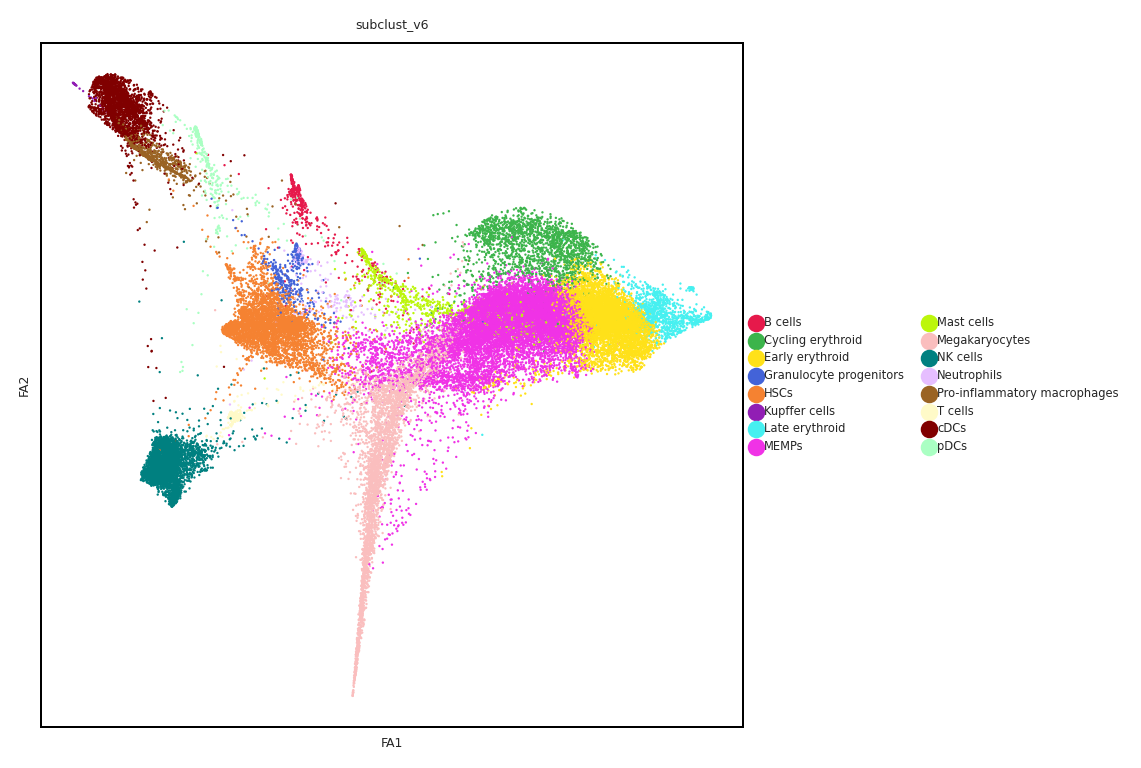

In [24]:
%matplotlib inline

sc.settings.set_figure_params(dpi=180, frameon=True, figsize=(5, 5), fontsize=5,facecolor='white')  # low dpi (dots per inch) yields small inline figures

# sc.pl.draw_graph(adata_paga, color=annotations,legend_loc='on data',show=True)

# Now plot the combined PAGA graph + embedding
# f, axs = plt.subplots(1,1,figsize=(25,30))
f_out2=".PAGA_trajectory_embedding_harmony.png"
sc.pl.draw_graph(adata_paga,
             color=annotations,
             palette=myColors,
             legend_loc='right margin',
             #ax=axs,
             show=True,
             # size=300,
             # legend_fontsize='large',
             save=f_out2
        )

# plt.tight_layout()
# plt.close("all")


In [25]:
# Compute the diffusion map
adata_paga.uns['iroot'] = np.flatnonzero(adata_paga.obs[annotations]==root_node)[0]
sc.tl.diffmap(adata_paga, n_comps=50)
sc.tl.dpt(adata_paga)

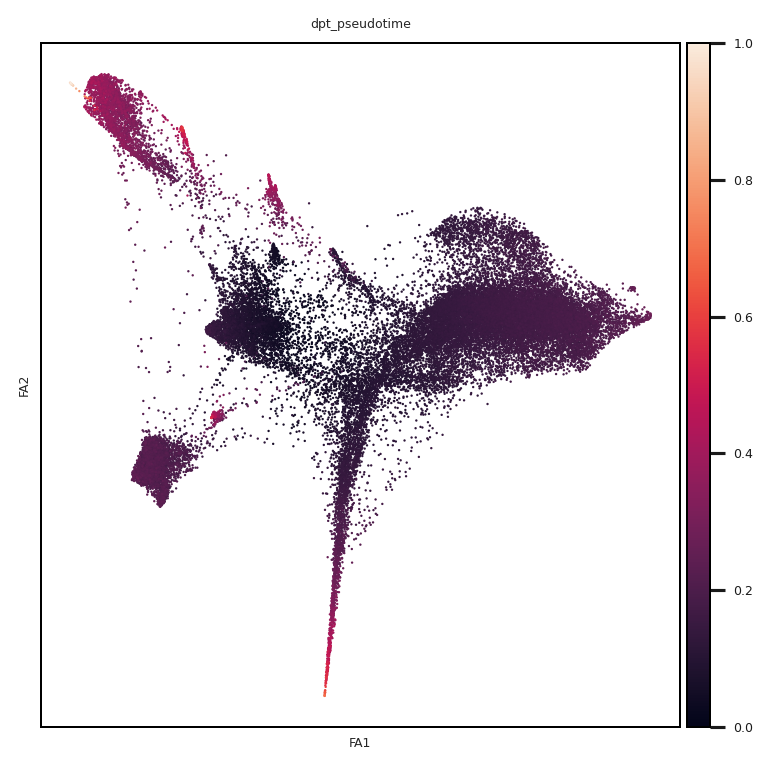

In [26]:
f_out3=".PAGA_diffusion_pseudotime_harmony.png".format(idtype)
sc.pl.draw_graph(adata_paga,
     color="dpt_pseudotime",
     legend_loc="right margin",
#      ax=axs,
     show=True,
#      size=300,
     legend_fontsize='large',
     save=f_out3
)
plt.close("all")

#######

In [27]:
# Plot the average pseudotimes
times = adata_paga.obs.groupby(by=annotations).mean()["dpt_pseudotime"].sort_values()
#uncs = adata_paga.obs.groupby(by=annotations).std()["dpt_pseudotime"].reindex(times.index) # Standard deviation
uncs = 2*1.96*adata_paga.obs.groupby(by=annotations).sem()["dpt_pseudotime"].reindex(times.index) # 95 % confidence from the standard error in the mean

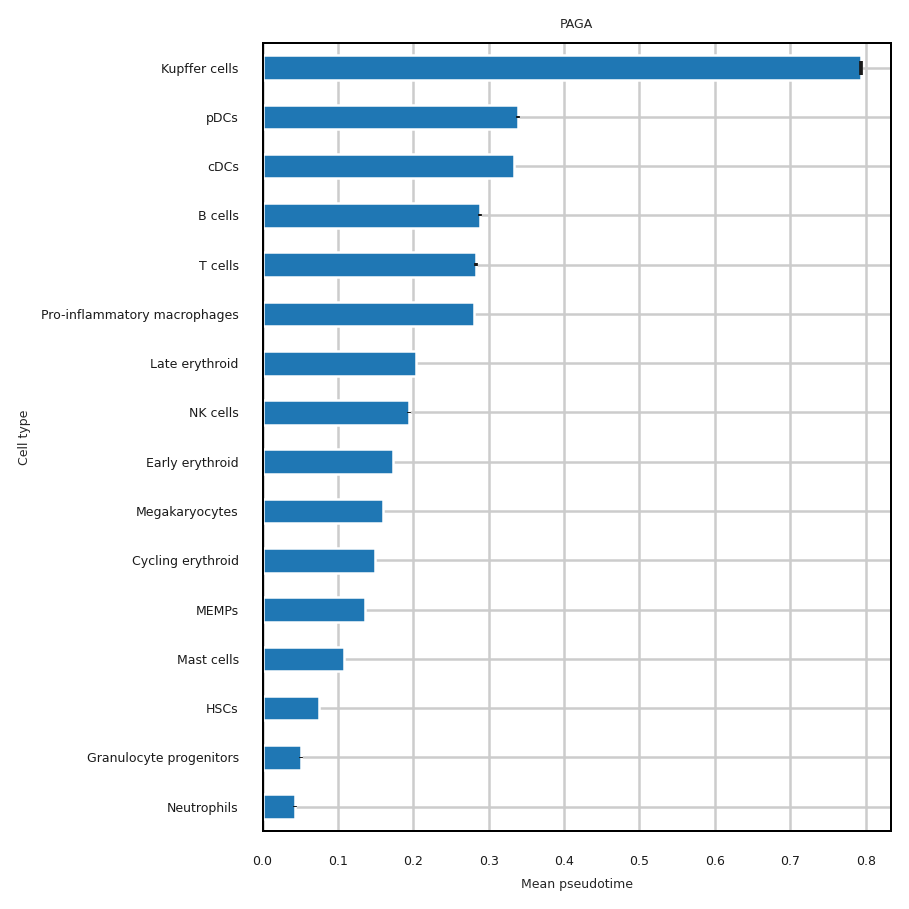

In [29]:
# f, axs = plt.subplots(1,1,figsize=(15,10))
f_out4="{0}/figures/PAGA_Mean_Pseudotimes_harmony.pdf".format(outDir)

pdf = mpdf.PdfPages(f_out4)
times.plot.barh(yerr=uncs)
plt.ylabel("Cell type")
plt.xlabel("Mean pseudotime")
plt.title("PAGA")
plt.tight_layout()
pdf.savefig()
plt.show()
plt.close("all")
pdf.close()

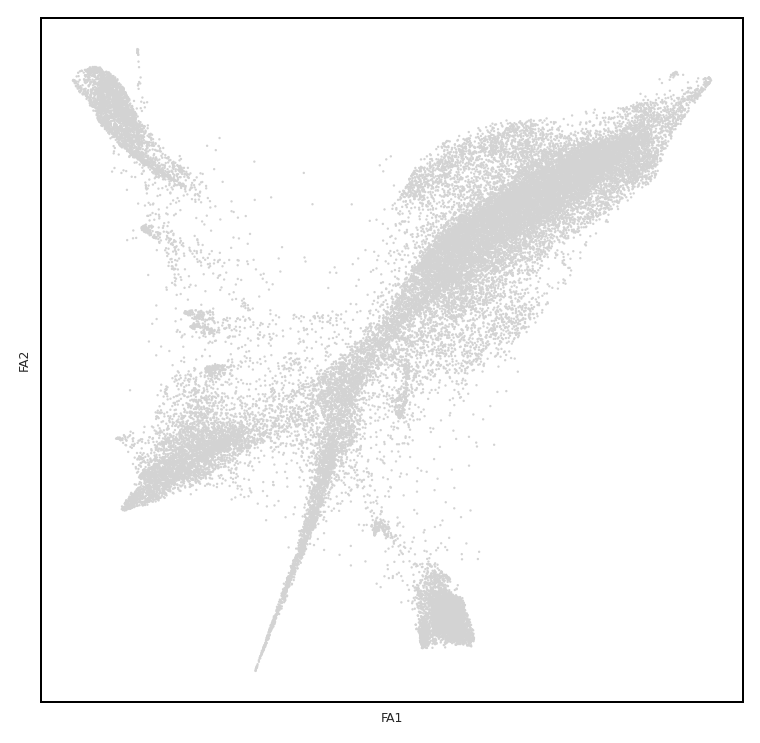

In [19]:
# # PAGA connection plot following comparison
# f_out5="{0}/figures/ATAC.PAGA_connections_harmony.pdf".format(outDir)
# # pdf = mpdf.PdfPages(".dfcombined.{0}.post_cluster_peaks.v2.res_0.6.chromvar_PAGA_connections_harmony.pdf")
# pdf = mpdf.PdfPages(f_out5)

f, axs = plt.subplots(1,1,figsize=(5,5))
sc.pl.draw_graph(adata_paga, 
                 # size=100, 
                 legend_fontsize="large", legend_loc="right margin", 
                 ax=axs, 
                 show=True,save=True)
# sc.pl.paga(adata_paga,
#    pos              = adata_paga.uns['paga']['pos'],
#    show             = False,
#    node_size_power  = 0.5,
#    ax               = axs,
#    threshold        = threshold,
#    node_size_scale  = 0.8,
#    edge_width_scale = 0.3,
#    fontsize         = 5,
#    text_kwds        = {'alpha':1})

# plt.tight_layout()
# plt.show()
# pdf.savefig()
# plt.close("all")

# pdf.close()

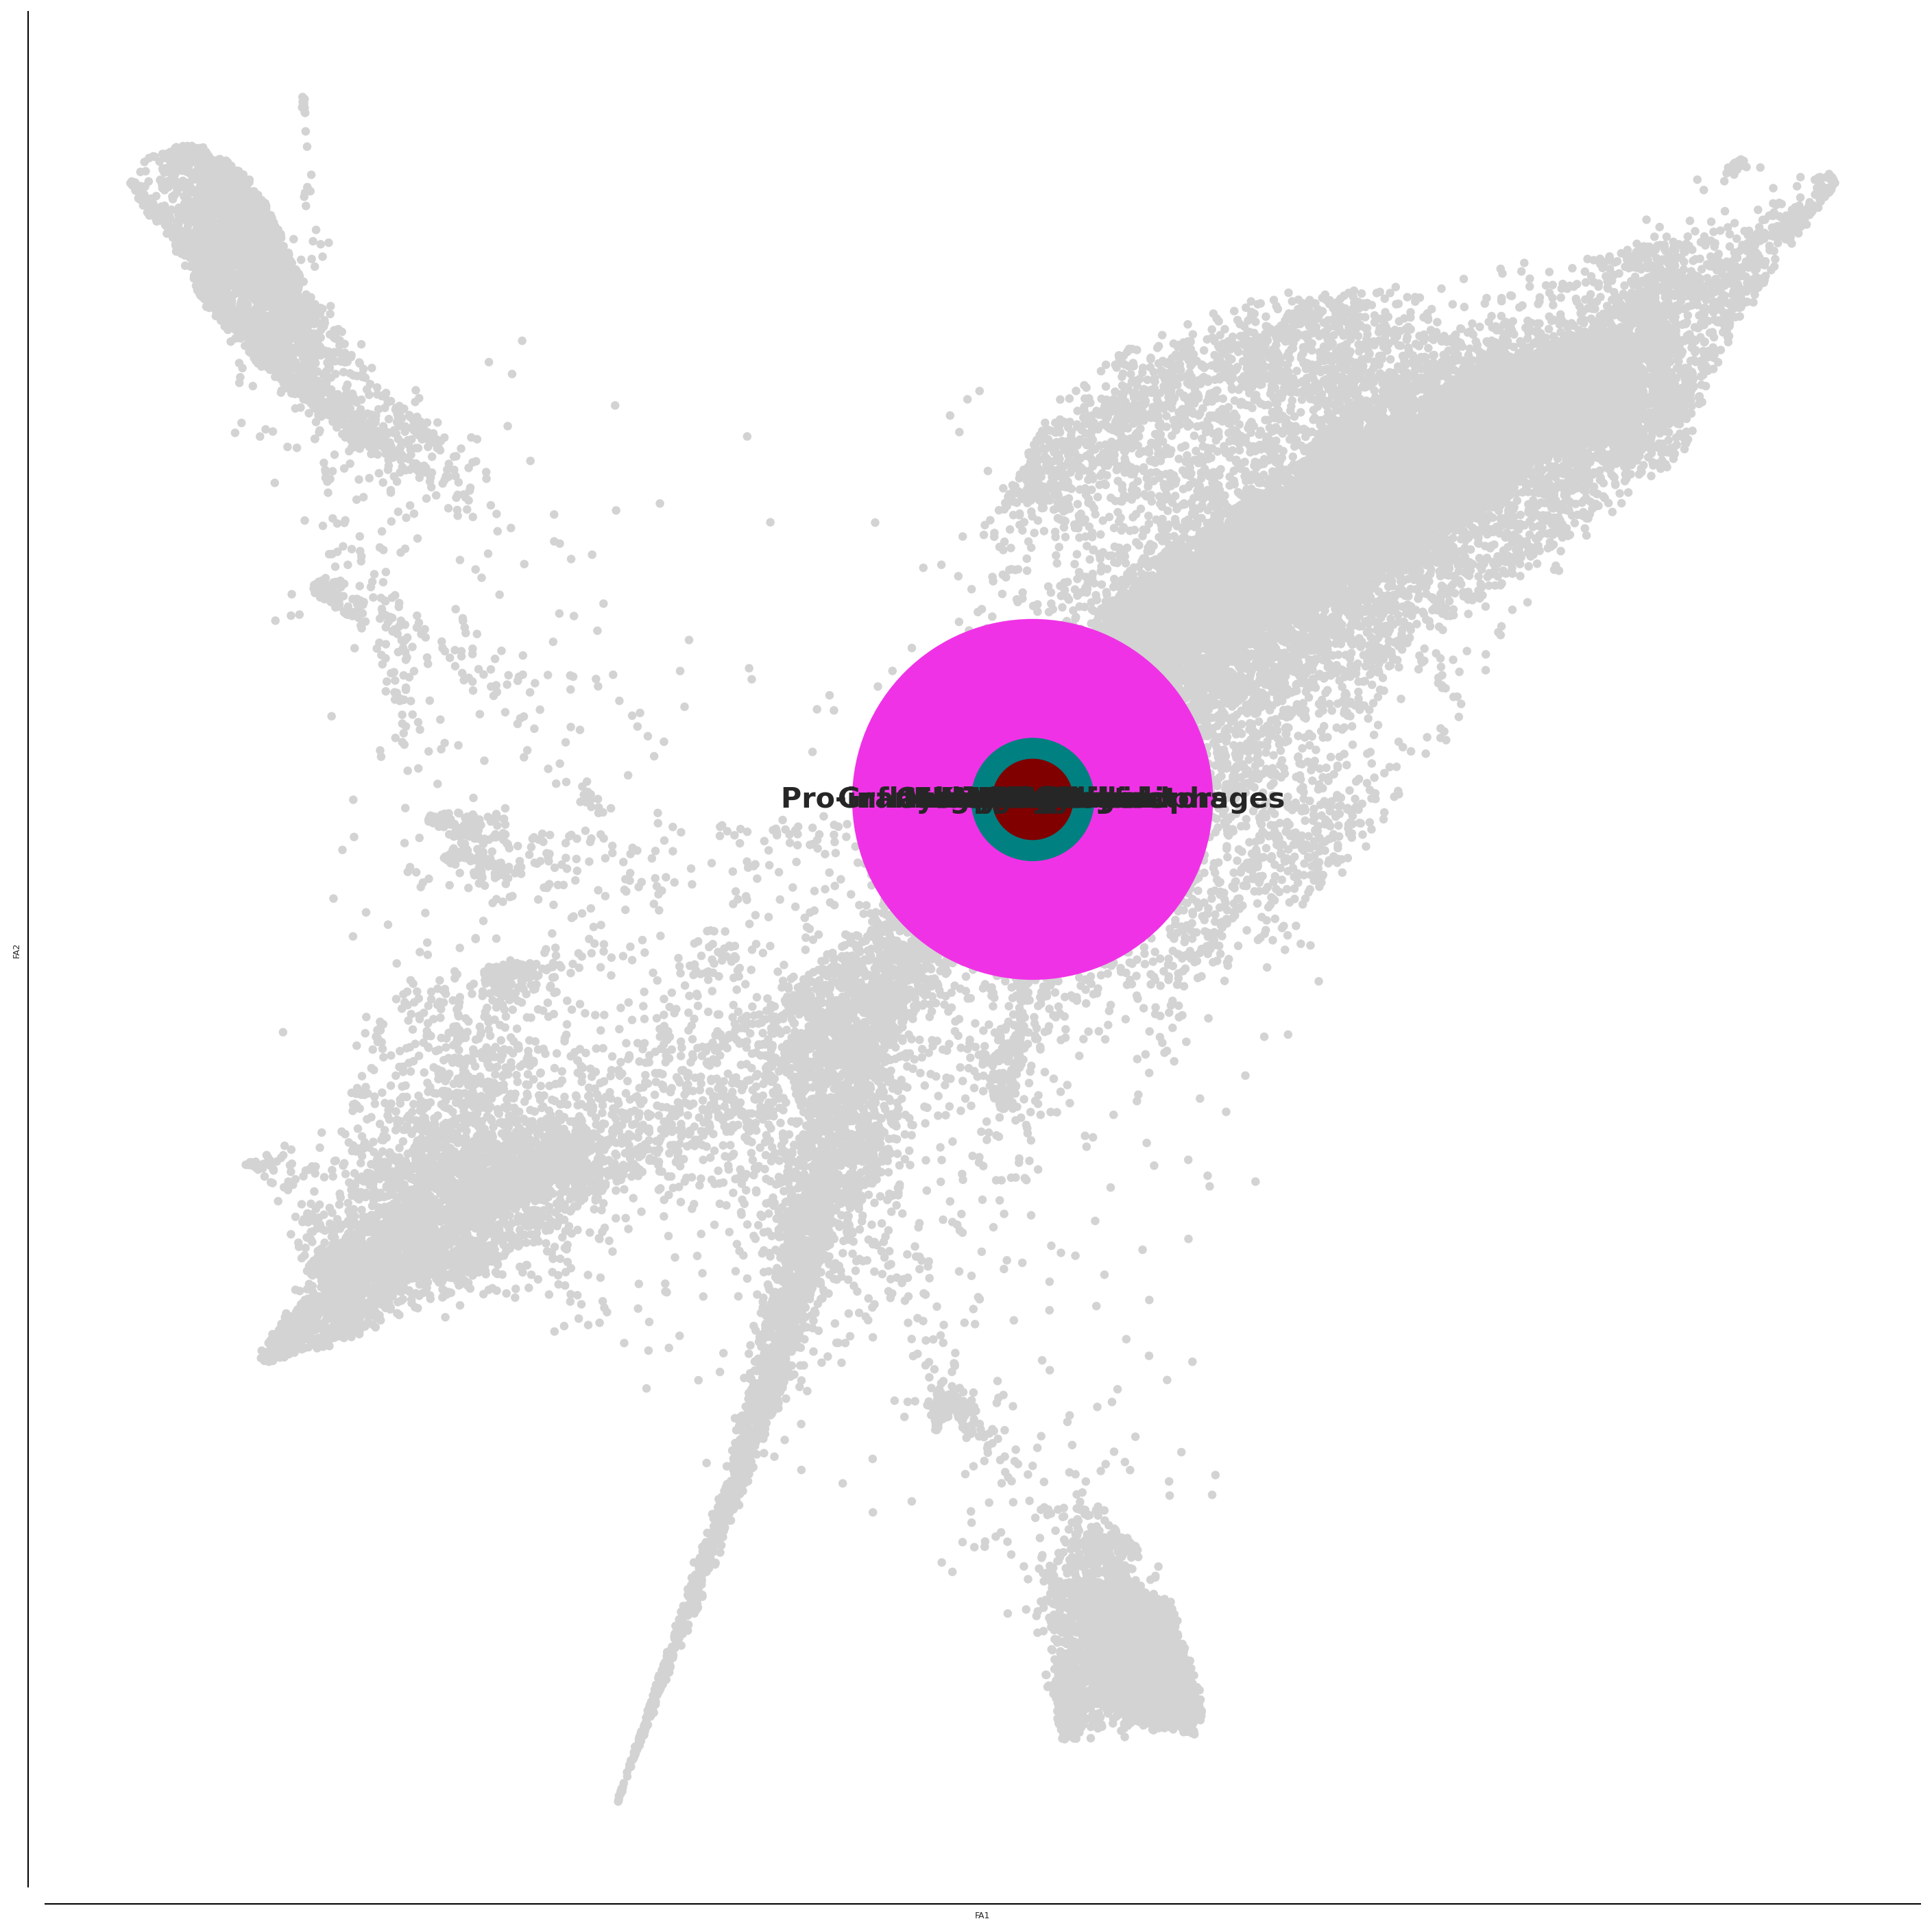

In [20]:
sc.tl.paga(adata_paga, groups=annotations)

f, axs = plt.subplots(1,1,figsize=(16,16))
sns.set(font_scale=1.5)
sns.set_style("white")

sc.pl.draw_graph(adata_paga, size=100, ax=axs, show=False)
sc.pl.paga(adata_paga,
           pos             = adata_paga.uns['paga']['pos'],
           init_pos = 'paga',
           show            = False,
           node_size_scale = 2,
           node_size_power = 2,
           ax              = axs,
           text_kwds       = {'alpha':1})


sns.despine(offset=10, trim=False)
plt.tight_layout()
plt.show(block=False)
plt.close("all")

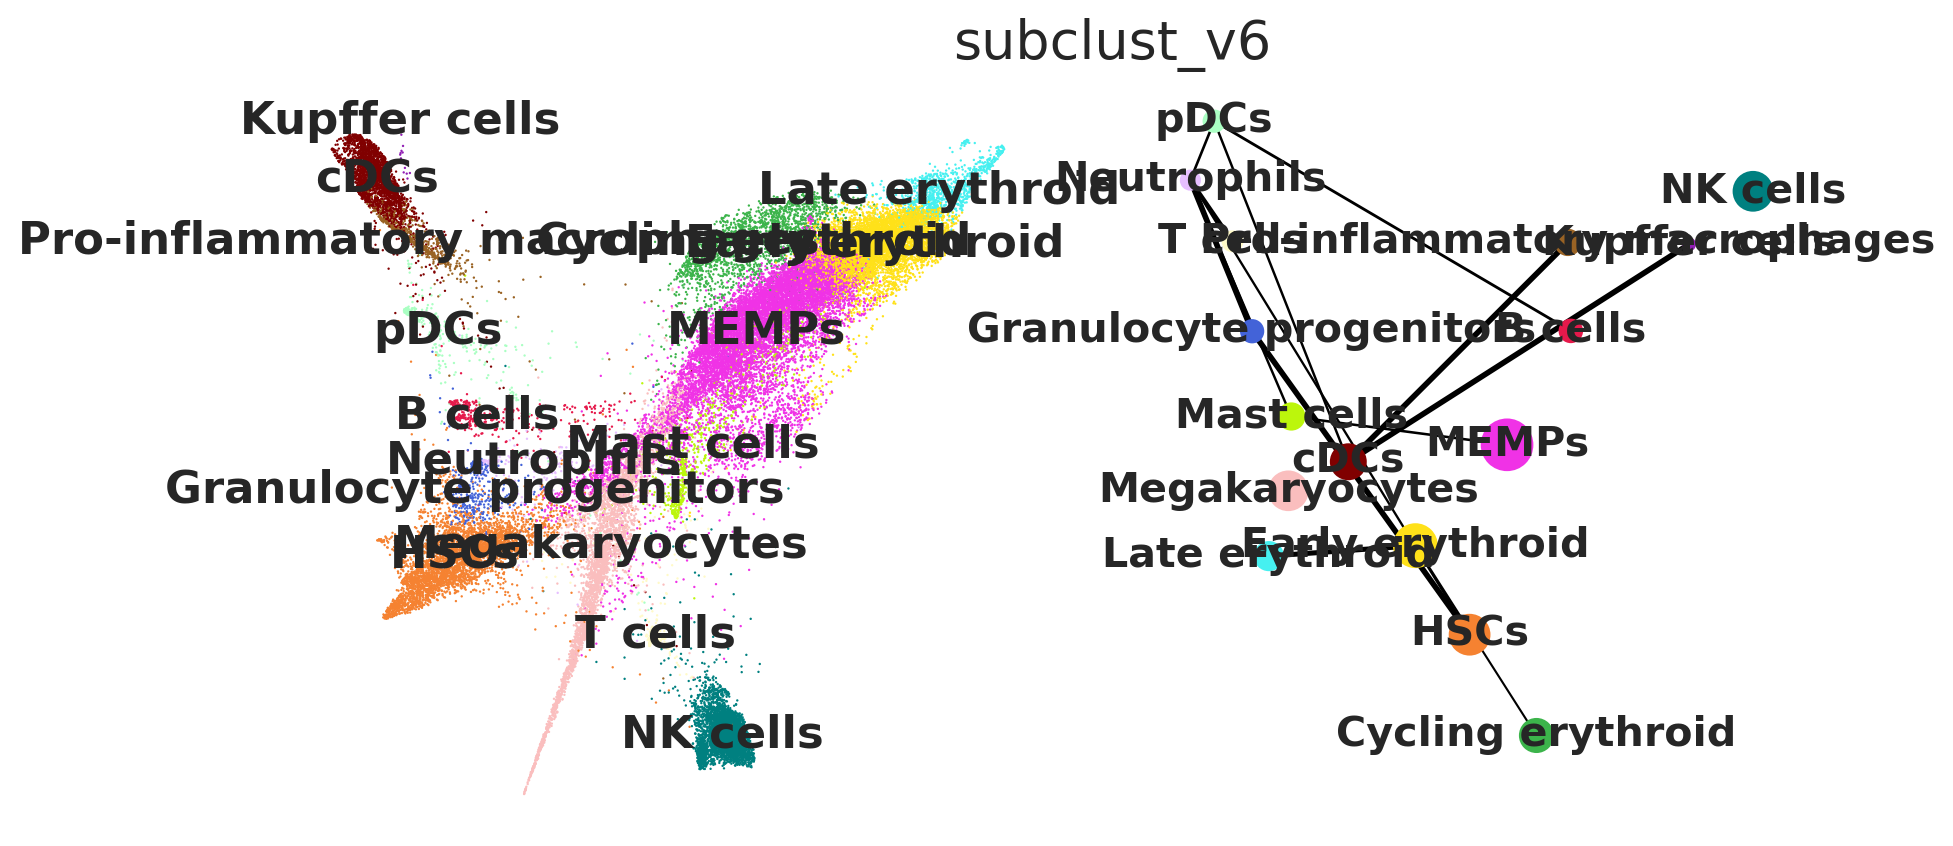

In [21]:
# f_out6="{0}/figures/ATAC.PAGA_compare.pdf".format(outDir)
# pdf = mpdf.PdfPages(f_out6)


# f, axs = plt.subplots(1,1,figsize=(5,5))

sc.pl.paga_compare(
    adata_paga, save=True,show=True,
    threshold        = threshold,
   node_size_scale  = 0.8,
   edge_width_scale = 0.3
)

# sc.pl.paga_compare(
#     adata_paga, threshold=0.2, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
#     legend_fontsize=12, fontsize=12, frameon=False, edges=True, ax = axs)
 #save=False,show=True,
   # ax=axs)

# plt.tight_layout()
# plt.show()
# plt.close("all")


In [ ]:
f_df_out = "/oak/stanford/groups/smontgom/amarder/neuro-variants/output/data/DS_Multiome_ds_v2/Multiome.RNA_only2.ds.paga.h5ad"

adata_paga.write(f_df_out, compression="gzip")



In [143]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# print(adata_paga.obs[annotations].unique())
print(adata_paga.obs[annotations].value_counts())
print(list(adata_paga.obs[annotations].unique()))

# pd.set_option('display.max_columns', 10)


MEMPs                           3939
B cells                         3407
HSCs                            2431
Megakaryocytes                  2394
Early erythroid                 1397
Pro-inflammatory macrophages    1347
NK cells                        1058
Mast cells                       998
Granulocyte progenitors          897
Kupffer cells                    725
Neutrophils                      439
pDCs                             418
Late erythroid                   318
Name: subclust_v6, dtype: int64
['Early erythroid', 'NK cells', 'Late erythroid', 'MEMPs', 'Megakaryocytes', 'Granulocyte progenitors', 'HSCs', 'Neutrophils', 'B cells', 'Mast cells', 'pDCs', 'Pro-inflammatory macrophages', 'Kupffer cells']
